In [1]:
import pandas as pd
import seaborn as sns
import fbprophet 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
def to_numeric_but(dataframe,save_these_columns='none',e='coerce'):
    '''
    split into 2 df and rejoin after convert to int
    
    inputs:
        >> save_these_columns=number of columns to save
            > currently must include one end of df 
                >> might could run function multiple times to edit slices
                >> single number, not range (yet)
                    > if 'none', saves no columns
        >> dataframe
            > dataframe to shif to numeric (but)
        >> e
            > for pd.to_numeric, errors=e
    output:
        >> concatted pd.DataFrame of 
            > og columns you chose to save
            > columns converted to numeric
    '''
    # copy df for editing
    k = dataframe.copy()
    
    # split
    if save_these_columns != 'none':
        # columns to save
        save_k = k[k.columns[:save_these_columns]]
        # columns to edit
        switch_k = k[k.columns[save_these_columns:]]
    # don't split
    else:
        # k as is
        switch_k = k

    # edited columns  # coerce , ignore , raise
    swapped_k = switch_k.apply(pd.to_numeric, errors=e)
    
    # check saving columns
    if save_these_columns != 'none':
        # new (edited) dataframe (ogsave|swapped)
        new_k = pd.concat( [save_k,swapped_k] ,axis=1 )
    else:
        new_k = swapped_k

    return new_k


def geography_to_zipcode_ids_to_numeric(dataframe):
    '''
    convert 
        >> .Geography values 
            > like 'ZCTA5 00601' 
            > to int(00601)
        >> .Id values
            > like '8600000US00601' 
            > to int(860000000601)
        >> .Id2 values
            > like '00601'
            > to int(00601)
    '''
    # copy
    df = dataframe.copy()
    
    # set old Geography
    geo = df.Geography
    # set old Id
    _id = df.Id
    # set old Id2
    __id2 = df.Id2
    
    # make new 'Geography' values
    new_geos = [int(i[-5:]) for i in geo]
    # new 'Id' values
    new_id = [int(''.join(i.split('US'))) for i in _id]
    # new .Id2 instances
    new__id2 = [int(d) for d in __id2]
    
    # convert dataframe
    new_df = df.copy()
    new_df.Geography = new_geos
    new_df.Id = new_id
    new_df.Id2 = new__id2
    
    # return new df
    return new_df

def kmeans_by(dataframe,n_clusters=10,converted=False):
    '''
    inputs:
        >> dataframe
            > dataframe to be edited
        >> n_clusters 
            > default = 10
            > number of clusters for KMeans
        >> converted
            > default = False
            > assumes data is not ready for KMeans 
                >> if True, assumes df is ready for KMeans
    output:
        > pd.Dataframe of 
    '''
    # copy data 
    d = dataframe.copy()  
    
    '''df conversion'''
    # default
    if converted!=True:
        # copy data for editing
        _data_ = d.copy()
        
        # convert first 3 columns ('Id', 'Id2', 'Geography')
        _data = geography_to_zipcode_ids_to_numeric(dataframe=_data_)
        
        # convert remainder of dataframe
        data = to_numeric_but(save_these_columns='none', dataframe=_data)
        print(len(data),len(data.columns))

    # dataframe has already been converted / otherwise
    if converted==True:
        data = d  
    
    '''KMeans'''
    # fill NaN values
    t = data.copy().fillna(0)
    
    # Convert DataFrame to matrix
    mat = t.values
    
    # Using sklearn
    km = KMeans(n_clusters)
    # fit our values
    km.fit(mat)
    
    # Get cluster assignment labels
    labels = km.labels_
    
    # Format results as a DataFrame
    results = pd.DataFrame([t.index,labels])

    # display results
    return results

In [3]:
# total population by county (adjusted to 2010 controls)
county_2010=pd.read_csv('../../data/NHGIS/nhgis0001_csv/nhgis0001_ts_geog2010_county.csv')
# total population by place
pop_by_place=pd.read_csv('../../data/NHGIS/nhgis0002_csv/nhgis0002_ts_nominal_place.csv',encoding='ISO-8859-1')

In [4]:
# Table 1: (CL8) Total Population
#         CL8AA:       Persons: Total
#         CL8AAL:      Lower bound: Persons: Total
#         CL8AAU:      Upper bound: Persons: Total

 
# Context Fields 
#         NHGISCODE:   NHGIS Integrated Geographic Unit Code
#         GJOIN1970:   GIS Join Match Code, 1970
#         GJOIN1980:   GIS Join Match Code, 1980
#         GJOIN1990:   GIS Join Match Code, 1990
#         GJOIN2000:   GIS Join Match Code, 2000
#         GJOIN2010:   GIS Join Match Code, 2010
#         GJOIN2012:   GIS Join Match Code, 2012
#         STATE:       NHGIS Integrated State Name
#         STATEFP:     FIPS State Code
#         STATENH:     NHGIS Integrated State Code
#         PLACE:       NHGIS Integrated Place Name
#         PLACEA:      NHGIS Integrated Place Code
#         NAME1970:    Area Name, 1970
#         NAME1980:    Area Name, 1980
#         NAME1990:    Area Name, 1990
#         NAME2000:    Area Name, 2000
#         NAME2010:    Area Name, 2010
#         NAME2012:    Area Name, 2012
 
# Table 1: (AV0) Total Population
#     Time series AA: Persons: Total
#         AV0AA1970:   1970: Persons: Total
#         AV0AA1980:   1980: Persons: Total
#         AV0AA1990:   1990: Persons: Total
#         AV0AA2000:   2000: Persons: Total
#         AV0AA2010:   2010: Persons: Total
#         AV0AA125:    2008-2012: Persons: Total
#         AV0AA125M:   Margin of error: 2008-2012: Persons: Total

In [5]:
highest_pop_2010 = pop_by_place.loc[pop_by_place.AV0AA2010.idxmax()]
for i in highest_pop_2010[22:24]:
    print(i)

8175133.0
8199221.0


- ***notes***: 
    - 2010: Persons: Total != 008-2012: Persons: Total 

In [6]:
print(len(pop_by_place.NHGISCODE),len(pop_by_place.NHGISCODE.unique()))

31436 31436


In [7]:
_x=(len(county_2010.DATAYEAR)/3)-1
print(_x,_x*2,_x*3,'\n',len(county_2010.DATAYEAR),len(county_2010.DATAYEAR.unique()))

3142.0 6284.0 9426.0 
 9429 3


In [8]:
county_2010.iloc[9428]

GISJOIN          G5600450
GEOGYEAR             2010
DATAYEAR             2010
STATE             Wyoming
STATEA                 56
COUNTY      Weston County
COUNTYA                45
CL8AA                7208
CL8AAL                NaN
CL8AAU                NaN
Name: 9428, dtype: object

In [9]:
'''Understanding STATEA'''
print(len(county_2010[:3142].STATEA.unique()),'\n',county_2010[:3142].STATEA.unique())

51 
 [ 1  2  4  5  6  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47 48 49 50 51 53
 54 55 56]


In [10]:
q=county_2010.copy()
idx=q.DATAYEAR
q=q.set_index(idx)
q[['GISJOIN', 'DATAYEAR', 'STATEA',
       'COUNTYA', 'CL8AA', 'CL8AAL', 'CL8AAU']]

,GISJOIN,DATAYEAR,STATEA,COUNTYA,CL8AA,CL8AAL,CL8AAU
DATAYEAR,,,,,,,
1990,G0100010,1990,1,1,34223.68,34222.0,34572.0
1990,G0100030,1990,1,3,98280.00,98280.0,98280.0
1990,G0100050,1990,1,5,25417.62,25417.0,25441.0
1990,G0100070,1990,1,7,16610.89,16470.0,16921.0
1990,G0100090,1990,1,9,39251.65,39074.0,39523.0
1990,G0100110,1990,1,11,10977.33,10954.0,11040.0
1990,G0100130,1990,1,13,21891.61,21791.0,21970.0
1990,G0100150,1990,1,15,116035.05,115968.0,116183.0
1990,G0100170,1990,1,17,36879.09,36857.0,36928.0


In [11]:
x=county_2010[:3142].copy()
y=county_2010[3143:6286].copy()
z=county_2010[6286:].copy()

x=x.apply(pd.to_numeric, errors='coerce')
x=x.dropna(axis=1, how='all')
y=y.apply(pd.to_numeric, errors='coerce')
y=y.dropna(axis=1, how='all')
z=z.apply(pd.to_numeric, errors='coerce')
z=z.dropna(axis=1, how='all')

a=kmeans_by(dataframe=x,n_clusters=31,converted=True)
b=kmeans_by(dataframe=y,n_clusters=31,converted=True)
c=kmeans_by(dataframe=z,n_clusters=31,converted=True)

In [12]:
a_i = a.loc[0]

In [13]:
b

,0,1,2,3,4,5,6,7,8,9,...,3133,3134,3135,3136,3137,3138,3139,3140,3141,3142
0,3143,3144,3145,3146,3147,3148,3149,3150,3151,3152,...,6276,6277,6278,6279,6280,6281,6282,6283,6284,6285
1,22,16,4,4,22,30,4,0,22,4,...,15,4,15,4,15,22,30,30,15,15


In [14]:
c

,0,1,2,3,4,5,6,7,8,9,...,3133,3134,3135,3136,3137,3138,3139,3140,3141,3142
0,6286,6287,6288,6289,6290,6291,6292,6293,6294,6295,...,9419,9420,9421,9422,9423,9424,9425,9426,9427,9428
1,12,13,23,26,17,0,26,7,23,23,...,0,23,0,23,0,12,26,26,0,0


In [15]:
pop_by_place.head()

,NHGISCODE,GJOIN1970,GJOIN1980,GJOIN1990,GJOIN2000,GJOIN2010,GJOIN2012,STATE,STATEFP,STATENH,...,NAME2000,NAME2010,NAME2012,AV0AA1970,AV0AA1980,AV0AA1990,AV0AA2000,AV0AA2010,AV0AA125,AV0AA125M
0,G01000100,NaN,NaN,NaN,NaN,G01000100,G01000100,Alabama,1,10,...,NaN,Abanda CDP,"Abanda CDP, Alabama",NaN,NaN,NaN,NaN,192.0,42.0,31.0
1,G01000124,G0100005,G0100005,G01000124,G01000124,G01000124,G01000124,Alabama,1,10,...,Abbeville city,Abbeville city,"Abbeville city, Alabama",2996.0,3155.0,3173.0,2987.0,2688.0,2699.0,18.0
2,G01000460,G0100010,G0100010,G01000460,G01000460,G01000460,G01000460,Alabama,1,10,...,Adamsville city,Adamsville city,"Adamsville city, Alabama",NaN,2498.0,4161.0,4965.0,4522.0,4537.0,26.0
3,G01000484,G0100015,G0100015,G01000484,G01000484,G01000484,G01000484,Alabama,1,10,...,Addison town,Addison town,"Addison town, Alabama",NaN,746.0,626.0,723.0,758.0,826.0,284.0
4,G01000676,G0100020,G0100020,G01000676,G01000676,G01000676,G01000676,Alabama,1,10,...,Akron town,Akron town,"Akron town, Alabama",NaN,604.0,468.0,521.0,356.0,369.0,141.0


In [16]:
len(pop_by_place.NHGISCODE),len(pop_by_place.NHGISCODE.unique())

(31436, 31436)

In [17]:
places = pop_by_place.NHGISCODE
# Table 1: (AV0) Total Population
#     Time series AA: Persons: Total
#         AV0AA1970:   1970: Persons: Total
#         AV0AA1980:   1980: Persons: Total
#         AV0AA1990:   1990: Persons: Total
#         AV0AA2000:   2000: Persons: Total
#         AV0AA2010:   2010: Persons: Total
#         AV0AA125:    2008-2012: Persons: Total
#         AV0AA125M:   Margin of error: 2008-2012: Persons: Total
# pop_by_place.loc(places[1])
places[1]

'G01000124'

In [18]:
# df.loc[df['column_name'] == some_value]
# pop_by_place.loc[pop_by_place.STATE=='Arkansas']
for i,place in enumerate(pop_by_place.PLACE):
    if 'San Francisco' in place:
        print(i,place)

3334 San Francisco city
3449 South San Francisco city


In [19]:
# list of 
# pleasanton 3200
# bentonville 1549
nyc=pop_by_place.iloc[[18672]][['NHGISCODE','PLACE','STATE','AV0AA1970','AV0AA1980', 'AV0AA1990', 'AV0AA2000','AV0AA2010']]
sfo= pop_by_place.iloc[[3334]][['NHGISCODE','PLACE','STATE','AV0AA1970','AV0AA1980', 'AV0AA1990', 'AV0AA2000','AV0AA2010']]
sfo
# testa=pop_by_place[['NHGISCODE','PLACE','STATE','AV0AA1970','AV0AA1980', 'AV0AA1990', 'AV0AA2000','AV0AA2010']]
# only keep columns with at least 5 non-NaN (aka 2 population measurements)
# testa.dropna(thresh=5)

,NHGISCODE,PLACE,STATE,AV0AA1970,AV0AA1980,AV0AA1990,AV0AA2000,AV0AA2010
3334,G06067000,San Francisco city,California,715674.0,678974.0,723959.0,776733.0,805235.0


In [20]:
# testb=pd.DataFrame(data=['place','1970','1980','1990','2000','2010','2008-2012'], index=['NHGISCODE','AV0AA1970','AV0AA1980', 'AV0AA1990', 'AV0AA2000','AV0AA2010', 'AV0AA125']).T
# testb
# testb=pd.DataFrame({'year': ['1970','1980','1990','2000','2010'],
#                        'month': [12,12,12,12,12],
#                        'day': [31,31,31,31,31]})
# testb=testb.T.apply(pd.to_datetime)
# testb

# df of years w/ columns same as pop_by_place
testb=pd.DataFrame(index=[1],data={'NHGISCODE':'x','AV0AA1970': '1970','AV0AA1980':'1980','AV0AA1990':'1990',"AV0AA2000":'2000',"AV0AA2010":'2010'})

# convert to datetime
testb=testb.apply(pd.to_datetime,errors='coerce')
testb

,NHGISCODE,AV0AA1970,AV0AA1980,AV0AA1990,AV0AA2000,AV0AA2010
1,NaT,1970-01-01,1980-01-01,1990-01-01,2000-01-01,2010-01-01


In [21]:
# put together 
# G01000124=pd.concat([testb,testa],axis=0)
G01000124=pd.concat([testb,sfo],axis=0)
# drop nan values columns (non-measured, etc)
G01000124=G01000124.dropna(axis=1)
# reset index (now == 0,1), transpose, then rename columns to Prophet standards
G01000124=G01000124.reset_index().T.rename(columns={0: 'ds', 1:'y'})
# has weird 'index' row at 0
G01000124=G01000124[1:]
G01000124

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,ds,y
AV0AA1970,1970-01-01 00:00:00,715674
AV0AA1980,1980-01-01 00:00:00,678974
AV0AA1990,1990-01-01 00:00:00,723959
AV0AA2000,2000-01-01 00:00:00,776733
AV0AA2010,2010-01-01 00:00:00,805235


In [22]:
"""
e.g. 1-measure city
ValueError: Dataframe has less than 2 non-NaN rows."""
# Make the prophet model and fit on the data
gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
gm_prophet.fit(G01000124)

# Make a future dataframe for 2 years
gm_forecast = gm_prophet.make_future_dataframe(periods=1 * 10, freq='Y')

# Make predictions
gm_forecast = gm_prophet.predict(gm_forecast)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.0.


In [23]:
gm_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1970-01-01,-676671.833637,715673.999994,715674.000006,-676671.833637,-676671.833637,1.392346e+06,1.392346e+06,1.392346e+06,1.392346e+06,1.392346e+06,1.392346e+06,0.0,0.0,0.0,715674.000000
1,1980-01-01,-720992.547231,678973.999994,678974.000005,-720992.547231,-720992.547231,1.399967e+06,1.399967e+06,1.399967e+06,1.399967e+06,1.399967e+06,1.399967e+06,0.0,0.0,0.0,678974.000000
2,1990-01-01,-668386.833637,723958.999994,723959.000006,-668386.833637,-668386.833637,1.392346e+06,1.392346e+06,1.392346e+06,1.392346e+06,1.392346e+06,1.392346e+06,0.0,0.0,0.0,723959.000000
3,2000-01-01,-623233.547231,776732.999994,776733.000006,-623233.547231,-623233.547231,1.399967e+06,1.399967e+06,1.399967e+06,1.399967e+06,1.399967e+06,1.399967e+06,0.0,0.0,0.0,776733.000000
4,2010-01-01,-587110.833637,805234.999994,805235.000006,-587110.833637,-587110.833637,1.392346e+06,1.392346e+06,1.392346e+06,1.392346e+06,1.392346e+06,1.392346e+06,0.0,0.0,0.0,805235.000000
5,2010-12-31,-583511.417335,817573.027237,817573.027250,-583511.417335,-583511.417335,1.401084e+06,1.401084e+06,1.401084e+06,1.401084e+06,1.401084e+06,1.401084e+06,0.0,0.0,0.0,817573.027244
6,2011-12-31,-579902.112528,818545.350590,818545.350605,-579902.112528,-579902.112528,1.398447e+06,1.398447e+06,1.398447e+06,1.398447e+06,1.398447e+06,1.398447e+06,0.0,0.0,0.0,818545.350597
7,2012-12-31,-576282.919214,825498.661272,825518.649557,-576282.919214,-576262.930941,1.401782e+06,1.401782e+06,1.401782e+06,1.401782e+06,1.401782e+06,1.401782e+06,0.0,0.0,0.0,825498.661280
8,2013-12-31,-572673.614406,829070.939920,830912.180750,-573104.651557,-571263.410728,1.402176e+06,1.402176e+06,1.402176e+06,1.402176e+06,1.402176e+06,1.402176e+06,0.0,0.0,0.0,829501.977068
9,2014-12-31,-569064.309599,830518.347060,835723.880371,-570566.097516,-565360.564208,1.401084e+06,1.401084e+06,1.401084e+06,1.401084e+06,1.401084e+06,1.401084e+06,0.0,0.0,0.0,832020.134980


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.0.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


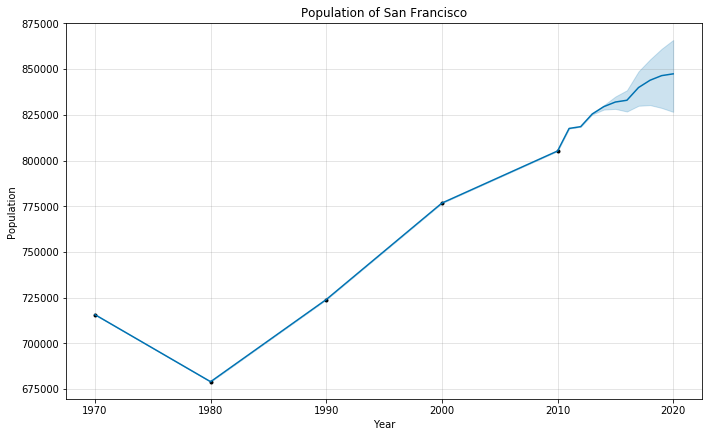

In [25]:
# Make the prophet model 
gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)

# fit model on our data
gm_prophet.fit(G01000124)

# Make a future dataframe for 2 years
gm_forecast = gm_prophet.make_future_dataframe(periods=1 * 10, freq='Y')

# Make predictions
gm_forecast = gm_prophet.predict(gm_forecast)

# # identify change points
# city_changepoints = [str(date) for date in tesla_prophet.changepoints]

gm_prophet.plot(gm_forecast, xlabel = 'Year', ylabel = 'Population')
plt.title('Population of San Francisco');

In [27]:
# gm_prophet.plot(gm_forecast, xlabel = 'Year', ylabel = 'Population')

# plt.title('Population of New York City');